## Neural Network, Image Recognition & Object Detection
By: Volker Felvic Katche Tachin

17th January 2023


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionb

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import keras as k
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization

import cv2
from tqdm import tqdm
from collections import Counter

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import plotly.express as px

In [3]:
# Define the base path for the dataset
path = "../input/planets-dataset/planet/planet/"

# Join the base path with the train-jpg folder
path_train = os.path.join(path, "train-jpg")

# Join the base path with the test-jpg folder
path_test = os.path.join(path, "test-jpg")

# Use the os.listdir function to get the number of files in the train-jpg and test-jpg folders
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)


train files: 40479, test files: 40669


In [4]:
# Define the path to the train_classes.csv file
path_train_class = os.path.join(path, "train_classes.csv")

# Read the train_classes.csv file and store it in a DataFrame
df_train = pd.read_csv(path_train_class)

# Print the shape of the DataFrame
print(df_train.shape)

# Display the first 5 rows of the DataFrame
df_train.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
# Number Of Unique Tags In The Dataset
# Avereage # Of Labels Per Image

all_tags = [item for sublist in list(df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))

total of 116278 non-unique tags in all training images


In [6]:
# Label Distribution

# Add a new column 'list_tags' to the DataFrame by splitting the 'tags' column on the space character
df_train["list_tags"] = df_train.tags.str.split(" ")

# Get the values of the new column
row_tags = df_train.list_tags.values

# Flatten the list of tags
tags = [tag for row in row_tags for tag in row]

# Count the occurrences of each tag
counter_tags = Counter(tags)

# Create a new DataFrame with the tag and total columns
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

# Create a bar chart of the tag distribution using Plotly
fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)

# Update the chart title
fig.update_layout(title="Tags distribution")

# Show the chart
fig.show()

# Machine Learning

## Data Preparation

In [7]:
# dropping previously created column
df_train.drop(columns = ['list_tags'], inplace = True)
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:

# Initialize empty lists to store the training images and their labels
x_train = []
y_train = []

# Function to flatten tags into a list
flatten = lambda l: [item for sublist in l for item in sublist]

# applying the function
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

# creating a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(df_train.values, miniters=1000):
    # Read the image file
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    # Initialize an array of zeros for the targets
    targets = np.zeros(17)
    # Loop through the tags for the current image
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # appending image and its labels to the appropriate list
    x_train.append(cv2.resize(img, (64, 64)))  # indicating the image size
    y_train.append(targets)

# Convert the lists to numpy arrays
x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)


100%|██████████| 40479/40479 [05:40<00:00, 118.99it/s]


In [9]:
# creating validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1111)

# Prints the shape of the training and validation data.
print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)

Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


In [10]:
gc.collect()

100

# Defining Metrics

In [11]:
# Defining a function that calculates the F-beta score for a given set of true labels and predicted labels.
# The function balances precision and recall and it is useful when there is an imbalance in the number of positive and negative examples in the data.

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # Clipping y_pred between 0 and 1
    y_pred = K.clip(y_pred, 0, 1)

    # Rounding y_pred to binary values
    y_pred_bin = K.round(y_pred + threshold_shift)

    # Counting true positives, false positives, and false negatives
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculating precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [12]:
# This code defines a function that calculates the accuracy score for a given set of true labels and predicted labels.
def accuracy_score(y_true, y_pred, epsilon = 1e-4):
    
    # casting the true labels and predicted labels to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    # counting the true positives
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    
    # counting the false positives
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    
    # counting the false negatives
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    # casting the true labels and predicted labels to boolean
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    
    # counting the true negatives
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    #calculating the accuracy score
    return (tp + tn)/(tp + tn + fp + fn + epsilon)


In [13]:
gc.collect()

23

# Building the Neural Network

In [14]:
# define the model
model = k.Sequential()

# add normalization to the input data
model.add(BatchNormalization(input_shape = (64, 64, 3)))

# adding convolution layers
model.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.25)) # to prevent overfitting

model.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

# flattening the convolution output
model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(17, activation = 'sigmoid'))

# compiling
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [fbeta, accuracy_score])

# training the model and saving the history
history = model.fit(x_train, y_train, batch_size = 128, epochs = 15, verbose = 1, validation_data = (x_val, y_val), \
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_fbeta', patience = 3, mode = 'max')])

2023-01-17 19:04:38.729515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 19:04:38.730544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 19:04:38.748336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 19:04:38.749160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 19:04:38.749972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/15


2023-01-17 19:04:51.570452: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


253/253 [==============================] - 25s 45ms/step - loss: 0.1984 - fbeta: 0.6984 - accuracy_score: 0.9220 - val_loss: 0.1966 - val_fbeta: 0.6995 - val_accuracy_score: 0.9180
Epoch 2/15
253/253 [==============================] - 9s 35ms/step - loss: 0.1545 - fbeta: 0.7693 - accuracy_score: 0.9390 - val_loss: 0.1458 - val_fbeta: 0.7838 - val_accuracy_score: 0.9435
Epoch 3/15
253/253 [==============================] - 9s 35ms/step - loss: 0.1412 - fbeta: 0.7886 - accuracy_score: 0.9440 - val_loss: 0.1374 - val_fbeta: 0.7981 - val_accuracy_score: 0.9468
Epoch 4/15
253/253 [==============================] - 9s 36ms/step - loss: 0.1321 - fbeta: 0.8042 - accuracy_score: 0.9477 - val_loss: 0.1277 - val_fbeta: 0.8051 - val_accuracy_score: 0.9508
Epoch 5/15
253/253 [==============================] - 9s 35ms/step - loss: 0.1254 - fbeta: 0.8146 - accuracy_score: 0.9500 - val_loss: 0.1293 - val_fbeta: 0.8117 - val_accuracy_score: 0.9494
Epoch 6/15
253/253 [==============================] - 9

In [15]:
gc.collect()

1813

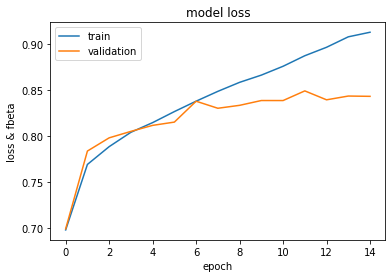

In [16]:
# Plotting the training and validation loss
# plt.plot(history.history['loss'])
plt.plot(history.history['fbeta'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['val_fbeta'])

# Adding title, y-label and x-label to the plot
plt.title('model loss')
plt.ylabel('loss & fbeta')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation',], loc='upper left')

# Showing the plot
plt.show()

In [17]:
# Evaluate the model on the validation set
model.evaluate(x_val, y_val)

# Calculate the f-beta score for the training set
train_fscore = fbeta_score(y_train, np.round(model.predict(x_train)), beta=2,average = 'weighted')
print("train fscore: ", train_fscore)

# Calculate the f-beta score for the validation set
val_fscore = fbeta_score(y_val, np.round(model.predict(x_val)), beta=2, average = 'weighted')
print("val fscore: ", val_fscore)

253/253 [==============================] - 1s 4ms/step - loss: 0.1543 - fbeta: 0.8440 - accuracy_score: 0.9533


2023-01-17 19:07:26.095045: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1591689216 exceeds 10% of free system memory.
2023-01-17 19:07:27.901482: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1591689216 exceeds 10% of free system memory.


train fscore:  0.9493035414786207
val fscore:  0.8367348105829974


# Evaluating with test data

In [18]:
# Read the sample submission CSV file and store it in a DataFrame
df_samplesub = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

# The DataFrame 'df_samplesub' now contains the data from the sample submission CSV file

In [19]:
# Create two separate DataFrames for the test and additional test files

# The first DataFrame will contain the labels for the test-jpg files
test = df_samplesub[0 : 40669]

# The second DataFrame will contain the labels for the test-jpg-additional files
files = df_samplesub[40669 : ]

In [20]:
gc.collect()

4917

In [21]:
# Loading the test images

# Initialize an empty list to store the images
test_img = []

# Loop through the test DataFrame
for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Loop through the additional test files DataFrame
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Convert the list of images to a numpy array and normalize the pixel values
test_img = np.array(test_img, np.float16)/255.0

100%|██████████| 20522/20522 [03:33<00:00, 96.30it/s] 


In [22]:
gc.collect()

23

In [23]:
# Running the predictions

# Initialize an empty list to store the predictions
yres = []

# Make predictions on the test images using the model
predictions = model.predict(test_img, batch_size = 64, verbose = 2)

# Append the predictions to the yres list
yres.append(predictions)

2023-01-17 19:17:21.431139: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3007660032 exceeds 10% of free system memory.


957/957 - 5s


In [24]:
gc.collect()

790

In [25]:
# Convert the encoded labels back to their original form

# Initialize an empty array to store the decoded labels
sub = np.array(yres[0])

# Loop through the encoded labels
for i in range (1, len(yres)):
    # Add the encoded label to the array
    sub += np.array(yres[i])

# Convert the array to a DataFrame
sub = pd.DataFrame(sub, columns = label_map)

In [ ]:
gc.collect()

In [26]:
# Create the submission file format

# Initialize an empty list to store the predictions
preds = []

# Loop through the sample submission DataFrame
for i in tqdm(range(sub.shape[0]), miniters=1000):
    # Get the i-th row of the DataFrame
    a = sub.loc[[i]]
    # Apply a lambda function to get a Boolean array indicating which columns have values greater than 0.2
    a = a.apply(lambda x: x > 0.2, axis=1)
    # Transpose the DataFrame
    a = a.transpose()
    # Get the rows where the Boolean array is True
    a= a.loc[a[i] == True]
    # Join the index of the DataFrame (which contains the tags) into a single string
    ' '.join(list(a.index))
    # Append the string of tags to the preds list
    preds.append(' '.join(list(a.index)))

# Assign the preds list as the 'tags' column of the sample submission DataFrame
df_samplesub['tags'] = preds

# Save the sample submission DataFrame to a CSV file
df_samplesub.to_csv('pred_submission.csv', index=False)

100%|██████████| 61191/61191 [01:58<00:00, 518.55it/s]
